In [1]:
import torch
import os
import csv
import math
import numpy as np

In [2]:
import sys
import os
from importlib import reload
here = os.getcwd()
sys.path.append(os.path.join(here,"../"))

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from models.cde.cde_data_common import process_data,get_final_linear_input_channels,get_final_indices,wrap_data,augment_data
import models.cde.cde_train_common as train_common
import models.cde.cde_data_common as cde_data_common
import explainer.rule_pattern_miner as rlm
import explainer.explainer_utils as eutils

from utils.test_utils import make_results_filenames

#from explainer.integrad import integrad
from explainer.FPGrowth_tree import *
from explainer.rule_pattern_miner import *
from explainer.explainer_utils import *
import explainer.RuleGrowth_tree as rgtree

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score,accuracy_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt 
import seaborn as sns

In [5]:
import explainer.explainer_utils as eutils
import models.cde as cde

In [6]:
def new_make_model():
    model, regularise = make_model()
    model.linear.weight.register_hook(lambda grad: 100 * grad)
    model.linear.bias.register_hook(lambda grad: 100 * grad)
    return model, regularise

In [7]:
def group_processed_data(X,y,times):
    X = torch.tensor(X)
    y = torch.tensor(y)
    final_indices,_ = get_final_indices(times,y)
    coeffs = process_data(times,X,intensity=args.intensity,time_intensity=args.time_intensity,cummean=cummean,cumsum=cumsum,append_times=args.append_times,interpolate=args.interpolate)
    return coeffs,y,final_indices

In [8]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--dpath',default='../data', help='Path to data file')
parser.add_argument('--rpath',default='./results', help='Path to save results')
parser.add_argument('--use_phys',action='store_true', help='Use physiology data or not')
parser.add_argument('--seed',default=0,type=int, help='Random seed')
parser.add_argument('--model_name',default='ncde',type=str, help='Model name')
parser.add_argument('--interpolate',default='cubic_spline',type=str, help='Interpolation function name')
parser.add_argument('--device',default='cpu',type=str, help='cpu or cuda')
parser.add_argument('--side_input',action='store_true', help='Use side input to final task')
parser.add_argument('--concat_z',action='store_true', help='Concat hidden states for the final task')
parser.add_argument('--time_intensity',action='store_true', help='Add time intensity')
parser.add_argument('--append_times',action='store_true', help='Append time indices as one feature')
parser.add_argument('--intensity',action='store_true', help='Add X intensity')
parser.add_argument('--time_len',default=12,type=int, help='Length of time indices')
parser.add_argument('--hidden_channels',default=2,type=int, help='Dimension of hidden states z')
parser.add_argument('--hidden_hidden_channels',default=128,type=int, help='Dimension of hidden units of f')
parser.add_argument('--num_hidden_layers',default=4,type=int, help='Number of hidden layers of f')
parser.add_argument('--batch_size',default=1024,type=int, help='Batch size')
parser.add_argument('--max_epochs',default=500,type=int, help='Maximum epochs')
parser.add_argument('--pos_weight',default=20,type=int, help='Weight of positive class')
parser.add_argument('--lr',default=0.0001,type=float, help='Raw learning rate')
parser.add_argument('--K',default=5,type=int, help='K-fold cross-validation')

args,_ = parser.parse_known_args()

#print(args)




model_name=args.model_name 
#device=args.device
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

    
args.interpolate = "linear"    
args.side_input = False
args.concat_z = True

args.time_intensity = True
args.intensity = True 

args.time_len = 72
args.max_epochs = 50
args.pos_weight = 20

hidden_channels=args.hidden_channels 
hidden_hidden_channels=args.hidden_hidden_channels 
num_hidden_layers=args.num_hidden_layers

batch_size = args.batch_size

lr = args.lr * (batch_size / 64)


dpath = args.dpath
use_phys = args.use_phys
concat_z = args.concat_z
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)

name = make_results_filenames(args,'sepsis')

num_classes = 2
cummean = True
cumsum = False

In [9]:
args.seed

0

In [10]:
pp = "/Users/chenyu/github/NDE-Models-DigitalHealth/"

In [11]:
base_loc = pp+'data/raw/sepsis/'
static_intensity = True
time_intensity = True

In [12]:
X_times = []
X_static = []
y = []
H = args.time_len
for filename in os.listdir(base_loc):
    if filename.endswith('.psv'):
        with open(os.path.join(base_loc,filename)) as file:
            time = []
            label = 0.0
            reader = csv.reader(file, delimiter='|')
            reader = iter(reader)
            next(reader)  # first line is headings
            prev_iculos = 0
            for line in reader:
                assert len(line) == 41
                # time values are 34 features
                *time_values, age, gender, unit1, unit2, hospadmtime, iculos, sepsislabel = line
                iculos = int(iculos)
                #print('iculos',iculos)
                if iculos > H:  # keep at most the first H hours
                    break
                ## padding nan for missing hours
                for iculos_ in range(prev_iculos + 1, iculos):
                    time.append([float('nan') for value in time_values])
                    #time.append(np.zeros(len(time_values))+np.nan)
                prev_iculos = iculos
                time.append([float(value) for value in time_values])
                label = max(label, float(sepsislabel))
            unit1 = float(unit1)
            unit2 = float(unit2)
            unit1_obs = not math.isnan(unit1)
            unit2_obs = not math.isnan(unit2)
            if not unit1_obs:
                unit1 = 0.
            if not unit2_obs:
                unit2 = 0.
            hospadmtime = float(hospadmtime)
            if math.isnan(hospadmtime):
                hospadmtime = 0.  # this only happens for one record
            static = [float(age), float(gender), unit1, unit2, hospadmtime]
            if static_intensity:
                static += [unit1_obs, unit2_obs]
            if len(time) > 2:
                if len(time) < H:
                    # padding less hours
                    for t in range(H-len(time)):
                        time.append([float('nan') for value in time_values])
                X_times.append(time)
                X_static.append(static)
                y.append(label)
    

In [13]:
len(X_times[0])

72

In [14]:
times = np.arange(args.time_len).astype(np.float32)
times = torch.tensor(times)

In [15]:
X_times = np.array(X_times)
X_static = np.array(X_static)
y = np.array(y)

In [16]:
X_times = X_times.astype(np.float32)
y = y.astype(np.float32)

In [17]:
X_times.shape,X_static.shape,y.shape

((40333, 72, 34), (40333, 7), (40333,))

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X_times,y,test_size=0.2,random_state=args.seed)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5,random_state=args.seed)

In [19]:
for c in range(X_times.shape[-1]):
    mi = X_train[:,:,c][~np.isnan(X_train[:,:,c])].min()
    ma = X_train[:,:,c][~np.isnan(X_train[:,:,c])].max()
    X_train[:,:,c] = (X_train[:,:,c] - mi)/(ma - mi)+1.
    X_test[:,:,c] = (X_test[:,:,c] - mi)/(ma - mi)+1.
    X_val[:,:,c] = (X_val[:,:,c] - mi)/(ma - mi)+1.
#     X_times[:,:,c][np.isnan(X_times[:,:,c])] = 0.  # fill in missing value

In [20]:
X_train.shape,X_test.shape,X_val.shape

((32266, 72, 34), (4033, 72, 34), (4034, 72, 34))

In [21]:
y_train.sum(),y_test.sum(),y_val.sum()

(1741.0, 225.0, 222.0)

In [22]:
(y_train==1).sum()/len(y_train),(y_test==1).sum()/len(y_test)

(0.05395772639930577, 0.05578973468881726)

In [23]:
X_train_raw = augment_data(torch.tensor(X_train),times,intensity=args.intensity,time_intensity=args.time_intensity,cummean=cummean,cumsum=cumsum,append_times=args.append_times)
X_test_raw = augment_data(torch.tensor(X_test),times,intensity=args.intensity,time_intensity=args.time_intensity,cummean=cummean,cumsum=cumsum,append_times=args.append_times)
X_val_raw = augment_data(torch.tensor(X_val),times,intensity=args.intensity,time_intensity=args.time_intensity,cummean=cummean,cumsum=cumsum,append_times=args.append_times)

In [24]:
train_data = group_processed_data(X_train,y_train,times)
test_data = group_processed_data(X_test,y_test,times)
val_data = group_processed_data(X_val,y_val,times)

check X torch.Size([32266, 72, 136])
check X torch.Size([4033, 72, 136])
check X torch.Size([4034, 72, 136])


In [25]:
input_channels = train_data[0][0].shape[-1]
output_channels = 1
stream = True if concat_z else False
input_channels

136

In [26]:
if concat_z or side_input:
    side_input_dim = cv_sets[0][0][-1].shape[-1] if args.side_input else 0
    final_linear_input_channels = get_final_linear_input_channels(hidden_channels,side_input_dim=side_input_dim,time_len=args.time_len)
else:
    final_linear_input_channels = None

In [27]:
make_model = train_common.make_model(model_name, input_channels, output_channels, hidden_channels,
                               hidden_hidden_channels, num_hidden_layers, use_intensity=False,
                              final_linear_input_channels=final_linear_input_channels, 
                              initial=True,side_input=args.side_input,append_times=args.append_times,interpolate=args.interpolate)


In [28]:
### uncomment this cell if need to train a new model
times, train_dataloader, val_dataloader, test_dataloader = wrap_data(times, train_data, val_data, test_data, device,
                                                                                    batch_size=batch_size,num_workers=0)

log,log_num = train_common.main(name, times, train_dataloader, val_dataloader, test_dataloader, device,
                   new_make_model, num_classes, args.max_epochs, lr, kwargs={'stream':stream}, pos_weight=torch.tensor(args.pos_weight),
                   step_mode=True,rpath=args.rpath)

interpolate linear


  0%|                                                                                                                      | 0/50 [00:00<?, ?it/s]

Starting training for model:

NeuralCDE(
  input_channels=136, hidden_channels=2, output_channels=1, initial=True
  (func): FinalTanh(
    input_channels: 136, hidden_channels: 2, hidden_hidden_channels: 128, num_hidden_layers: 4
    (linear_in): Linear(in_features=2, out_features=128, bias=True)
    (linears): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (linear_out): Linear(in_features=128, out_features=272, bias=True)
  )
  (initial_network): Linear(in_features=136, out_features=2, bias=True)
  (linear): Linear(in_features=144, out_features=1, bias=True)
)




  2%|██▏                                                                                                           | 1/50 [00:50<41:07, 50.35s/it]

Epoch: 0  Train loss: 2.44  Train auroc: 0.729  Val loss: 2.45  Val auroc: 0.707


 22%|███████████████████████▉                                                                                     | 11/50 [07:11<26:08, 40.22s/it]

save model
Epoch: 10  Train loss: 2.16  Train auroc: 0.792  Val loss: 2.14  Val auroc: 0.798


 42%|█████████████████████████████████████████████▊                                                               | 21/50 [13:27<19:21, 40.04s/it]

save model
Epoch: 20  Train loss: 1.98  Train auroc: 0.853  Val loss: 2.0  Val auroc: 0.843


 62%|███████████████████████████████████████████████████████████████████▌                                         | 31/50 [19:42<12:40, 40.00s/it]

save model
Epoch: 30  Train loss: 1.87  Train auroc: 0.858  Val loss: 1.94  Val auroc: 0.838


 82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 41/50 [25:58<06:02, 40.25s/it]

save model
Epoch: 40  Train loss: 1.81  Train auroc: 0.864  Val loss: 1.89  Val auroc: 0.84


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [31:39<00:00, 37.98s/it]

save model
Epoch: 49  Train loss: 1.75  Train auroc: 0.866  Val loss: 1.81  Val auroc: 0.842
best epoch 49


#####################
test_metrics
{'accuracy': 0.7565104365348816, 'confusion': array([[2193.,  708.],
       [  40.,  131.]]), 'dataset_size': 3072, 'loss': 1.845547080039978, 'auroc': 0.8373317529144013, 'average_precision': 0.37709622003712423, 'sensitivity': 0.7660818713450293, 'specificity': 0.7559462254395036}
#####################
val_metrics
{'accuracy': 0.7626953125, 'confusion': array([[2222.,  692.],
       [  37.,  121.]]), 'dataset_size': 3072, 'loss': 1.8003116846084595, 'auroc': 0.8396979227300766, 'average_precision': 0.34048381575904074}
#####################
train_metrics
{'accuracy': 0.7601751685142517, 'confusion': array([[22739.,  7286.],
       [  327.,  1392.]]), 'dataset_size': 31744, 'loss': 1.7561373710632324, 'auroc': 0.8651600009493737, 'average_precision': 0.4072001526818935}


In [29]:
raw_feature_names = ['HR','O2Sat','Temp','SBP','MAP','DBP','Resp','EtCO2','BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2',
                    'AST','BUN','Alkalinephos','Calcium','Chloride','Creatinine','Bilirubin_direct','Glucose','Lactate','Magnesium',
                    'Phosphate','Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen','Platelets']

In [30]:
latent_feature_names = [r'$z_'+str(i)+'(t_{'+str(h)+'})$' for h in range(args.time_len) for i in range(hidden_channels) ]
intensity_feature_names = [rf+'_ctime' for rf in raw_feature_names] + [rf+'_cmax' for rf in raw_feature_names] + [rf+'_cmean' for rf in raw_feature_names] 
input_feature_names = raw_feature_names + intensity_feature_names
feature_types = ["int" if "ctime" in fn else "float" for fn in input_feature_names] 
len(input_feature_names)

136

In [31]:
## load model
#args.model_path = pp+"xncde/notebooks/results/sepsis/intensity_time_intensity_concatz/zdim2_hdim128_nlayer4_bs1024/posw20/interp_cubic_spline/model_2"
args.model_path = "./results/sepsis/intensity_time_intensity_concatz/zdim2_hdim128_nlayer4_bs1024/posw20/interp_linear/model_5"
model, regularise_parameters = make_model()
model.load_state_dict(torch.load(args.model_path))
model.to('cpu')
model.eval()

interpolate linear


NeuralCDE(
  input_channels=136, hidden_channels=2, output_channels=1, initial=True
  (func): FinalTanh(
    input_channels: 136, hidden_channels: 2, hidden_hidden_channels: 128, num_hidden_layers: 4
    (linear_in): Linear(in_features=2, out_features=128, bias=True)
    (linears): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (linear_out): Linear(in_features=128, out_features=272, bias=True)
  )
  (initial_network): Linear(in_features=136, out_features=2, bias=True)
  (linear): Linear(in_features=144, out_features=1, bias=True)
)

In [32]:
model.append_times=args.append_times
train_reps = model.latent_representation(X_train_raw,times=times).detach()
test_reps = model.latent_representation(X_test_raw,times=times).detach()
val_reps = model.latent_representation(X_val_raw,times=times).detach()

In [33]:
baselines = gen_intgrad_baselines(X_train_raw,y_train,train_reps)
subset = gen_balanced_subset(X_train_raw,y_train,size_per_class=int(y_train.sum()))

In [34]:
int_g, z_shift = eutils.calc_baselines_intg(test_examples=subset,model=model,baselines=baselines,times=times,C=2)

In [35]:
z_shift.shape,int_g.shape

(torch.Size([3482, 72, 2]), torch.Size([3482, 72, 2, 136]))

In [36]:
linear_prams = []
for p in model.linear.parameters():
    p = p.detach()
    print(p.shape,p)
    linear_prams.append(p)

torch.Size([1, 144]) tensor([[ 0.8458,  0.0342,  0.2073,  0.0715,  0.0446, -0.0260, -0.0186,  0.0668,
          0.0811,  0.0339,  0.0355, -0.0697,  0.0227, -0.1034, -0.0990, -0.0796,
          0.0068, -0.0650,  0.0505, -0.0518,  0.0352, -0.0057,  0.0031,  0.0738,
          0.0297,  0.0977,  0.0369,  0.0164,  0.0080, -0.0187,  0.0912,  0.0573,
          0.0792, -0.0595,  0.0617,  0.0225,  0.1012, -0.0789,  0.0494, -0.0791,
          0.0788,  0.0440,  0.0443, -0.0770, -0.0381, -0.0236, -0.0109, -0.0010,
          0.0343,  0.0176,  0.0647, -0.0237,  0.0036, -0.0425,  0.0471, -0.0647,
          0.0063,  0.0180, -0.0632,  0.0484, -0.0623, -0.0349,  0.0476,  0.0436,
         -0.0483, -0.0446,  0.0272,  0.0311, -0.0816, -0.0606,  0.0692,  0.0163,
          0.0740,  0.0425,  0.0419,  0.0969,  0.0171, -0.0224,  0.0381,  0.0842,
          0.0523,  0.0194,  0.0015,  0.0091, -0.0507,  0.0342,  0.0063, -0.0331,
          0.0517, -0.0699, -0.0679,  0.0814, -0.0130, -0.0676, -0.0334, -0.0493,
       

In [39]:
pred_y_train = (torch.matmul(train_reps.reshape(train_reps.shape[0],-1),linear_prams[0].transpose(1,0))+linear_prams[1]).numpy().reshape(-1)
pred_y_test = (torch.matmul(test_reps.reshape(test_reps.shape[0],-1),linear_prams[0].transpose(1,0))+linear_prams[1]).numpy().reshape(-1)
pred_y_val = (torch.matmul(val_reps.reshape(val_reps.shape[0],-1),linear_prams[0].transpose(1,0))+linear_prams[1]).numpy().reshape(-1)

y threshold 0.6425661


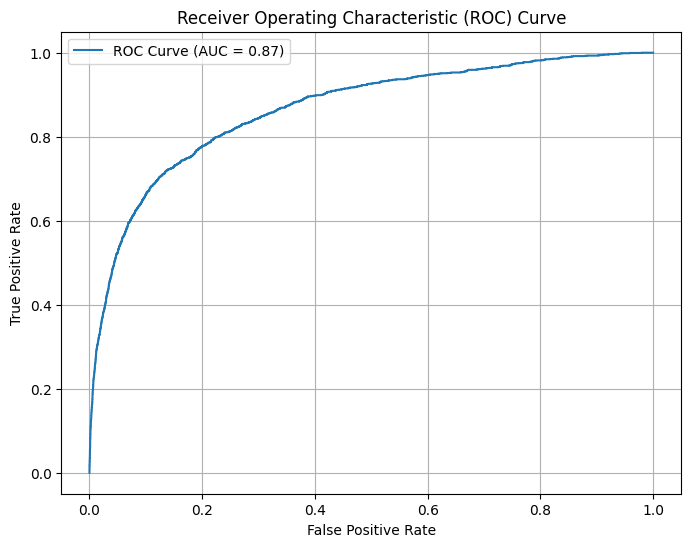

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import scipy as sp

pred_y = sp.special.expit(pred_y_train)
auc = roc_auc_score(y_train, pred_y)
fpr, tpr, thresholds = roc_curve(y_train, pred_y)
y_thd = thresholds[np.argmax(tpr - fpr)]
print("y threshold",y_thd)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

In [41]:
C=2
baseline_reps = model.latent_representation(baselines,times=times)
baseline_output = model.linear(baseline_reps.reshape(baseline_reps.shape[0],-1)).detach()

subset_reps,subset_output = [],[]
for k in range(C):
    subset_reps.append(model.latent_representation(subset[k],times=times))
    subset_output.append(model.linear(subset_reps[k].reshape(subset_reps[k].shape[0],-1)).detach())

In [42]:
cids = np.arange(C)
yshift = []
for k in cids:
    for kk in cids[cids!=k]:
        yshift.append(subset_output[k]-baseline_output[kk])
yshift = torch.vstack(yshift)

In [43]:
weights = linear_prams[0].reshape(-1,args.hidden_channels)
y_int_g = output_intg_score(int_g,weights,yshift)
y_int_g[torch.isnan(y_int_g)] = 0.

In [73]:
thds = np.linspace(0.01,0.05,500)
f_n = []
for thd in thds:
    mask = torch.abs(y_int_g) >= thd 
    f_n.append((thd,(mask.sum(dim=0)>=len(y_int_g)*0.99).sum()))
    print(f_n[-1])
    if f_n[-1][1]==0:
        break
thd = f_n[-2][0]
thd

(0.01, tensor(36))
(0.010080160320641282, tensor(36))
(0.010160320641282566, tensor(35))
(0.010240480961923848, tensor(34))
(0.010320641282565131, tensor(34))
(0.010400801603206413, tensor(33))
(0.010480961923847695, tensor(32))
(0.010561122244488979, tensor(32))
(0.01064128256513026, tensor(32))
(0.010721442885771544, tensor(32))
(0.010801603206412826, tensor(30))
(0.010881763527054108, tensor(30))
(0.010961923847695391, tensor(30))
(0.011042084168336673, tensor(30))
(0.011122244488977957, tensor(30))
(0.011202404809619239, tensor(29))
(0.01128256513026052, tensor(29))
(0.011362725450901804, tensor(27))
(0.011442885771543086, tensor(27))
(0.01152304609218437, tensor(26))
(0.011603206412825652, tensor(26))
(0.011683366733466934, tensor(25))
(0.011763527054108217, tensor(24))
(0.011843687374749499, tensor(23))
(0.011923847695390781, tensor(22))
(0.012004008016032065, tensor(22))
(0.012084168336673346, tensor(22))
(0.01216432865731463, tensor(22))
(0.012244488977955912, tensor(22))
(0.01

0.02210420841683367

Text(0, 0.5, 'Log number of features with max frequecy')

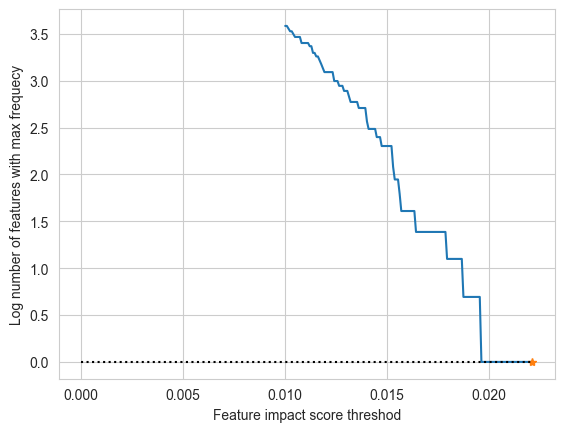

In [74]:
import seaborn as sns
sns.set_style("whitegrid")
plt.plot([th[0] for th in f_n[:-1]],[np.log(th[1].numpy()) for th in f_n[:-1]])
plt.plot(f_n[-2][0],np.log(f_n[-2][1].numpy()),"*")
plt.plot([0,f_n[-2][0]],[np.log(f_n[-2][1].numpy()),np.log(f_n[-2][1].numpy())],":k")
#plt.xlim(0.01,0.04)
#plt.ylim(0.,750)
plt.xlabel("Feature impact score threshod")
plt.ylabel("Log number of features with max frequecy")
#plt.savefig("./results/sepsis/scan_thd_demo.eps",bbox_inches="tight")

In [75]:
itemsets_y = transform_intgrad_to_itemsets(y_int_g,thd=thd,K=1)
fids = gen_freq_feature_set(itemsets_y[0],min_support=1500,max_len=100)
fids = np.array(fids).astype(int)-1
print('feature set',fids,len(fids))

[6703.0] 3448.0
[6703.0, 5071.0] 3408.0
[6703.0, 5071.0, 7655.0] 3383.0
[6703.0, 5071.0, 7655.0, 9014.0] 3366.0
[6703.0, 5071.0, 7655.0, 9014.0, 6295.0] 3344.0
[6703.0, 5071.0, 7655.0, 9014.0, 6295.0, 7657.0] 3326.0
[6703.0, 5071.0, 7655.0, 9014.0, 6295.0, 7657.0, 8470.0] 3325.0
[6703.0, 5071.0, 7655.0, 9014.0, 6295.0, 7657.0, 8470.0, 8334.0] 3324.0
[6703.0, 5071.0, 7655.0, 9014.0, 6295.0, 7657.0, 8470.0, 8334.0, 6567.0] 3323.0
[6703.0, 5071.0, 7655.0, 9014.0, 6295.0, 7657.0, 8470.0, 8334.0, 6567.0, 8335.0] 3307.0
[6703.0, 5071.0, 7655.0, 9014.0, 6295.0, 7657.0, 8470.0, 8334.0, 6567.0, 8335.0, 6158.0] 3273.0
[6703.0, 5071.0, 7655.0, 9014.0, 6295.0, 7657.0, 8470.0, 8334.0, 6567.0, 8335.0, 6158.0, 9694.0] 3257.0
[6703.0, 5071.0, 7655.0, 9014.0, 6295.0, 7657.0, 8470.0, 8334.0, 6567.0, 8335.0, 6158.0, 9694.0, 4663.0] 3215.0
[6703.0, 5071.0, 7655.0, 9014.0, 6295.0, 7657.0, 8470.0, 8334.0, 6567.0, 8335.0, 6158.0, 9694.0, 4663.0, 6022.0] 3205.0
[6703.0, 5071.0, 7655.0, 9014.0, 6295.0, 7657.0,

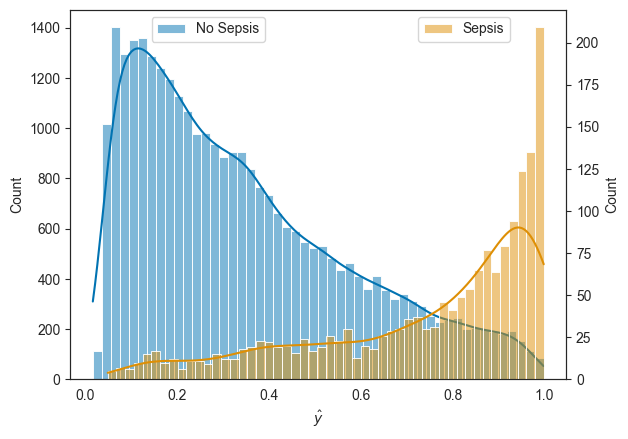

In [47]:
sns.set_style("white")
cmap = sns.color_palette("colorblind")
fig, ax1 = plt.subplots()
sns.histplot(pred_y[y_train==0],kde=True,ax=ax1,bins=50,color=cmap[0],label="No Sepsis")
ax2 = ax1.twinx()
sns.histplot(pred_y[y_train==1],kde=True,ax=ax2,bins=50,color=cmap[1],label="Sepsis")
ax1.set_xlabel(r"$\hat{y}$")
ax1.legend(loc='upper left', bbox_to_anchor=(0.15, 1.))
ax2.legend(loc='upper right', bbox_to_anchor=(0.9, 1.))
#plt.savefig("./results/sepsis/pred_y_hist.svg",bbox_inches="tight")

In [48]:
# thd_h = eutils.find_py_threshold(p_grids=np.linspace(0.7,1.,31),pred_y_prob=pred_y,true_y=y_train)
# thd_l = eutils.find_py_threshold(p_grids=np.linspace(0.1,.5,41),pred_y_prob=pred_y,true_y=y_train,c=0,high=False)

# thd_h,thd_l

In [68]:
(y_train==1).sum(),((y_train==1).sum()/len(y_train)),((pred_y>y_thd).sum()/len(pred_y))

(1741, 0.05395772639930577, 0.1674827992313891)

In [82]:
x = X_train_raw.reshape(X_train_raw.shape[0],-1).numpy()
y_rule_candidates = rlm.gen_rule_list_for_one_target_greedy(x,fids,pred_y>y_thd,y=y_train,c=1,sort_by="cond_prob_y",
                                                            min_support=500,num_grids=100,max_depth=3,top_K=10,
                                                            local_x=None,feature_types=feature_types*args.time_len,
                                                            verbose=False)

build_rule_tree
init rule tree
search rule for feature 6702
check potential rule 6702 4.2805465769508775 41.58585858585859 43.56565656565657 597
add rule [] 6702 (4.2805465769508775, 41.58585858585859, 43.56565656565657, 597)
search rule for feature 5070
check potential rule 5070 1.0585106382978724 29.77777777777778 31.646464646464647 564
add rule [6702] 5070 (1.0585106382978724, 29.77777777777778, 31.646464646464647, 564)
search rule for feature 7654
no valid rule,skip 7654
search rule for feature 9013
check potential rule 9013 1.084457616640605 57.666666666666664 67.0 514
add rule [6702, 5070] 9013 (1.084457616640605, 57.666666666666664, 67.0, 514)
check potential rule 6702 3.91554448073413 38.61616161616162 40.5959595959596 674
add rule [] 6702 (3.91554448073413, 38.61616161616162, 40.5959595959596, 674)
search rule for feature 5070
check potential rule 5070 1.0625799037563743 26.78787878787879 28.656565656565657 630
add rule [6702] 5070 (1.0625799037563743, 26.78787878787879, 28.65

In [83]:
for i, rules in enumerate(y_rule_candidates):   
    rules["rules"] = rlm.replace_feature_names(rules["rules"],input_feature_names,time_index=True)
    y_rule_candidates[i] = rules
y_rule_candidates

[{'rules': [(6702, 'MAP_ctime_t49', '>=', 42.0),
   (6702, 'MAP_ctime_t49', '<=', 43.0),
   (5070, 'MAP_ctime_t37', '>=', 30.0),
   (5070, 'MAP_ctime_t37', '<=', 31.0),
   (9013, 'SBP_ctime_t66', '>=', 58.0)],
  'cond_prob_target': 0.8229571984435797,
  'support': 514,
  'cond_prob_y': 0.5,
  'ratio_y': 0.1476163124641011},
 {'rules': [(6702, 'MAP_ctime_t49', '>=', 38.0),
   (6702, 'MAP_ctime_t49', '<=', 49.0),
   (5070, 'MAP_ctime_t37', '>=', 30.0),
   (5070, 'MAP_ctime_t37', '<=', 31.0),
   (7654, 'MAP_ctime_t56', '>=', 49.0)],
  'cond_prob_target': 0.7584369449378331,
  'support': 563,
  'cond_prob_y': 0.458259325044405,
  'ratio_y': 0.1481906950028719},
 {'rules': [(6702, 'MAP_ctime_t49', '>=', 39.0),
   (6702, 'MAP_ctime_t49', '<=', 40.0),
   (5070, 'MAP_ctime_t37', '>=', 27.0),
   (5070, 'MAP_ctime_t37', '<=', 28.0),
   (9013, 'SBP_ctime_t66', '>=', 56.0)],
  'cond_prob_target': 0.7495590828924162,
  'support': 567,
  'cond_prob_y': 0.20987654320987653,
  'ratio_y': 0.06835152211

In [71]:
y_rule_candidates = rlm.gen_rule_list_for_one_target_greedy(x,fids,pred_y<=y_thd,y=y_train,c=0,sort_by="cond_prob_y",
                                                            min_support=10000,num_grids=100,max_depth=3,top_K=10,
                                                            local_x=None,feature_types=feature_types*args.time_len,
                                                            verbose=False)

build_rule_tree
init rule tree
search rule for feature 6702
check potential rule 6702 1.110693849652196 7.92929292929293 18.81818181818182 10129
add rule [] 6702 (1.110693849652196, 7.92929292929293, 18.81818181818182, 10129)
search rule for feature 7654
check potential rule 7654 1.00240665418354 8.919191919191919 57.0 10068
add rule [6702] 7654 (1.00240665418354, 8.919191919191919, 57.0, 10068)
search rule for feature 5070
check potential rule 5070 1.0007315962736374 1.0 14.828282828282829 10038
add rule [6702, 7654] 5070 (1.0007315962736374, 1.0, 14.828282828282829, 10038)
check potential rule 7654 1.00240665418354 8.919191919191919 57.0 10068
add rule [6702] 7654 (1.00240665418354, 8.919191919191919, 57.0, 10068)
search rule for feature 5070
check potential rule 5070 1.0007315962736374 1.0 14.828282828282829 10038
add rule [6702, 7654] 5070 (1.0007315962736374, 1.0, 14.828282828282829, 10038)
check potential rule 7654 1.00240665418354 8.919191919191919 57.0 10068
add rule [6702] 765

check potential rule 5070 1.0035842351334316 1.0 12.95959595959596 10017
add rule [6702, 7654] 5070 (1.0035842351334316, 1.0, 12.95959595959596, 10017)
check potential rule 5070 1.0035842351334316 1.0 12.95959595959596 10017
add rule [6702, 7654] 5070 (1.0035842351334316, 1.0, 12.95959595959596, 10017)
check potential rule 5070 1.0020624588673854 1.0 17.81818181818182 10293
add rule [6702, 7654] 5070 (1.0020624588673854, 1.0, 17.81818181818182, 10293)
check potential rule 7654 1.0168909996958848 16.838383838383837 30.97979797979798 10337
add rule [6702] 7654 (1.0168909996958848, 16.838383838383837, 30.97979797979798, 10337)
search rule for feature 5070
check potential rule 5070 1.0035842351334316 1.0 12.95959595959596 10017
add rule [6702, 7654] 5070 (1.0035842351334316, 1.0, 12.95959595959596, 10017)
check potential rule 5070 1.0035842351334316 1.0 12.95959595959596 10017
add rule [6702, 7654] 5070 (1.0035842351334316, 1.0, 12.95959595959596, 10017)
check potential rule 5070 1.0020624

In [72]:
for i, rules in enumerate(y_rule_candidates):   
    rules["rules"] = rlm.replace_feature_names(rules["rules"],input_feature_names,time_index=True)
    y_rule_candidates[i] = rules
y_rule_candidates

[{'rules': [(6702, 'MAP_ctime_t49', '>=', 6.0),
   (6702, 'MAP_ctime_t49', '<=', 17.0),
   (7654, 'MAP_ctime_t56', '>=', 13.0),
   (5070, 'MAP_ctime_t37', '>=', 1.0),
   (5070, 'MAP_ctime_t37', '<=', 9.0)],
  'cond_prob_target': 0.9477783325012481,
  'support': 10015,
  'cond_prob_y': 0.9794308537194208,
  'ratio_y': 0.3213431613431613},
 {'rules': [(6702, 'MAP_ctime_t49', '>=', 8.0),
   (6702, 'MAP_ctime_t49', '<=', 19.0),
   (7654, 'MAP_ctime_t56', '>=', 15.0),
   (5070, 'MAP_ctime_t37', '>=', 1.0),
   (5070, 'MAP_ctime_t37', '<=', 17.0)],
  'cond_prob_target': 0.9386454183266932,
  'support': 10040,
  'cond_prob_y': 0.9771912350597609,
  'ratio_y': 0.3214086814086814},
 {'rules': [(6702, 'MAP_ctime_t49', '>=', 8.0),
   (6702, 'MAP_ctime_t49', '<=', 19.0),
   (7654, 'MAP_ctime_t56', '>=', 15.0),
   (5070, 'MAP_ctime_t37', '>=', 1.0),
   (5070, 'MAP_ctime_t37', '<=', 14.0)],
  'cond_prob_target': 0.9392121575684863,
  'support': 10002,
  'cond_prob_y': 0.9771045790841831,
  'ratio_y':

In [51]:
pred_y_t = sp.special.expit(pred_y_test)
tid = np.arange(len(y_test))[y_test==1][3]
x = X_train_raw.reshape(X_train_raw.shape[0],-1).numpy()
xi = X_test_raw[tid,:,:]
pred_y_test[tid],y_test[tid],pred_y_t[tid]

(-0.9137324, 1.0, 0.28623667)

In [52]:
## check global rules that match the selected sample
match = rlm.match_sample_rules(xi.reshape(-1),y_rule_candidates,time_dim=False,num_latent_per_time=2)
for mr in match:
    print(rlm.display_rules(mr,x,pred_y_train>=0.8,y=y_train,c=1,verbose=False))

In [53]:
## find local rules for pattern of class 1
local_rules = rlm.gen_rule_list_for_one_target_greedy(x,fids,pred_y>=thd_h,y=y_train,c=1,sort_by="cond_prob_target",
                                                            min_support=500,num_grids=100,max_depth=5,top_K=10,
                                                            local_x=xi.reshape(-1),feature_types=feature_types*args.time_len,
                                                            verbose=False)

build_rule_tree
init rule tree
search rule for feature 6702
no matched interval, search from local val grid
check potential rule 6702 1.468689549221561 1.0 2.97979797979798 2254
add rule [] 6702 (1.468689549221561, 1.0, 2.97979797979798, 2254)
search rule for feature 6157
check potential rule 6157 1.184739737026169 1.9090909090909092 46.0 1037
add rule [6702] 6157 (1.184739737026169, 1.9090909090909092, 46.0, 1037)
search rule for feature 7654
check potential rule 7654 1.9113657141171958 1.0 4.959595959595959 534
add rule [6702, 6157] 7654 (1.9113657141171958, 1.0, 4.959595959595959, 534)
search rule for feature 5070
no matched interval, search from local val grid
no valid rule,skip 5070
search rule for feature 6021
check potential rule 6021 1.0070874524714828 1.8888888888888888 45.0 526
add rule [6702, 6157, 7654] 6021 (1.0070874524714828, 1.8888888888888888, 45.0, 526)
search rule for feature 7656
no matched interval, search from local val grid
no valid rule,skip 7656
search rule for

no matched interval, search from local val grid
no valid rule,skip 7656
search rule for feature 9149
check potential rule 9149 1.00199203187251 1.676767676767677 57.84848484848485 502
add rule [6702, 6157, 7654] 9149 (1.00199203187251, 1.676767676767677, 57.84848484848485, 502)
search rule for feature 9424
no matched interval, search from local val grid
no valid rule,skip 9424
search rule for feature 9013
no matched interval, search from local val grid
no valid rule,skip 9013
search rule for feature 9693
no matched interval, search from local val grid
no valid rule,skip 9693
search rule for feature 7651
check potential rule 7651 1.0039999999999998 1.0 48.515151515151516 500
add rule [6702, 6157, 7654, 9149] 7651 (1.0039999999999998, 1.0, 48.515151515151516, 500)
check potential rule 7651 1.0039999999999998 1.0 48.515151515151516 500
add rule [6702, 6157, 7654, 9149] 7651 (1.0039999999999998, 1.0, 48.515151515151516, 500)
check potential rule 7651 1.0039999999999998 1.0 48.5151515151515

In [ ]:
for i, rules in enumerate(local_rules):   
    rules["rules"] = rlm.replace_feature_names(rules["rules"],input_feature_names,time_index=True)
    local_rules[i] = rules

local_rules

In [ ]:
## find local rules for pattern of class 0
local_rules = rlm.gen_rule_list_for_one_target_greedy(x,fids,pred_y<=thd_l,y=y_train,c=0,sort_by="cond_prob_y",
                                                            min_support=5000,num_grids=100,max_depth=5,top_K=10,
                                                            local_x=xi.reshape(-1),feature_types=feature_types*args.time_len,
                                                            verbose=False)

In [ ]:
for i, rules in enumerate(local_rules):   
    rules["rules"] = rlm.replace_feature_names(rules["rules"],input_feature_names,time_index=True)
    local_rules[i] = rules

local_rules

In [62]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.tree import plot_tree,export_text,export_graphviz
import explainer.DT_rules as dtr
from explainer.DT_rules import obtain_rule_lists_from_DT,select_rule_list

In [63]:
X_tr = X_train_raw.reshape(X_train_raw.shape[0],-1).numpy()
X_tr[np.isnan(X_tr)] = 0.
treemodel = DecisionTreeClassifier(max_depth=3,min_samples_leaf=1000)
treemodel.fit(X_tr,pred_y>y_thd)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=1000)

In [64]:
feature_names = [f+"_t"+str(t) for t in range(args.time_len) for f in input_feature_names ]

In [65]:
len(feature_names)

9792

In [66]:
rule_list, rule_value_list, rule_support_list, new_lines = dtr.obtain_rule_lists_from_DT(treemodel,5,X_tr,y_train,pred_y>y_thd,np.arange(X_tr.shape[-1]),feature_names,c=1)

In [67]:
select = [[],[],[]]
for s in range(len(rule_list)):
    select[0].append(rule_list[s])
    #select[1].append(rule_value_list[s])
    select[2].append(rule_support_list[s])
    print('#################')
    print(rule_list[s])
    print('cond_prob_target',rule_support_list[s][1].round(3),'cond_prob_y',rule_support_list[s][2].round(3),'size',rule_support_list[s][0])
    for r in rule_list[s]:
        print(feature_names[r[0]],r[1],r[2])

#################
[(4253, '<=', 17.5), (7888, '<=', 1.073), (9168, '<=', 67.5)]
cond_prob_target 0.225 cond_prob_y 0.06 size 8220
SBP_ctime_t31 <= 17.5
HR_t58 <= 1.073
Lactate_ctime_t67 <= 67.5
#################
[(4253, '<=', 17.5), (7888, '<=', 1.073), (9168, '>', 67.5)]
cond_prob_target 0.02 cond_prob_y 0.016 size 18083
SBP_ctime_t31 <= 17.5
HR_t58 <= 1.073
Lactate_ctime_t67 > 67.5
#################
[(4253, '<=', 17.5), (7888, '>', 1.073)]
cond_prob_target 0.645 cond_prob_y 0.154 size 1343
SBP_ctime_t31 <= 17.5
HR_t58 > 1.073
#################
[(4253, '>', 17.5), (3708, '<=', 24.5), (1262, '<=', 4.5)]
cond_prob_target 0.492 cond_prob_y 0.172 size 1600
SBP_ctime_t31 > 17.5
Temp_ctime_t27 <= 24.5
MAP_ctime_t9 <= 4.5
#################
[(4253, '>', 17.5), (3708, '<=', 24.5), (1262, '>', 4.5)]
cond_prob_target 0.063 cond_prob_y 0.019 size 1066
SBP_ctime_t31 > 17.5
Temp_ctime_t27 <= 24.5
MAP_ctime_t9 > 4.5
#################
[(4253, '>', 17.5), (3708, '>', 24.5)]
cond_prob_target 0.751 cond

In [160]:
treemodel = DecisionTreeClassifier(max_depth=3,min_samples_leaf=20000)
treemodel.fit(X_tr,pred_y<y_thd)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=20000)

In [161]:
rule_list, rule_value_list, rule_support_list, new_lines = dtr.obtain_rule_lists_from_DT(treemodel,5,X_tr,y_train,pred_y<y_thd,np.arange(X_tr.shape[-1]),feature_names,c=0)

IndexError: list index out of range

In [153]:
select = [[],[],[]]
for s in range(len(rule_list)):
    select[0].append(rule_list[s])
    #select[1].append(rule_value_list[s])
    select[2].append(rule_support_list[s])
    print('#################')
    print(rule_list[s])
    print('cond_prob_target',rule_support_list[s][1].round(3),'cond_prob_y',rule_support_list[s][2].round(3),'size',rule_support_list[s][0])
    for r in rule_list[s]:
        print(feature_names[r[0]],r[1],r[2])

#################
[(9700, '<=', 71.5)]
cond_prob_target 0.629 cond_prob_y 0.914 size 14141
FiO2_ctime_t71 <= 71.5
#################
[(9700, '>', 71.5)]
cond_prob_target 0.878 cond_prob_y 0.971 size 18125
FiO2_ctime_t71 > 71.5


In [159]:
y_train.sum(),(y_train==0).sum()

(1741.0, 30525)

In [ ]:
# z_int_g = (int_g/z_shift.unsqueeze(3)).numpy()
# z_int_g[np.isnan(z_int_g)] = 0.

# K = int(args.time_len * args.hidden_channels)
# itemsets = transform_intgrad_to_itemsets(z_int_g,thd=0.01,K=K)
# for k in range(K):
#     print(k,len(itemsets[k]))

# top_latent = torch.argsort(torch.abs(all_reps.reshape(all_reps.shape[0],-1)*linear_prams[0]).mean(dim=0),descending=True)[:20].numpy()
# top_latent

In [ ]:
# latent_num = 2
# z_rules = {}
# zw = (linear_prams[0][0]>0).numpy()

# for l in top_latent:
#     l = int(l)
#     print('### latent state {} ###'.format(l))
#     time_step= int(l/latent_num)
#     latent_id = int(l%latent_num)
    
#     z = all_reps[:,time_step,latent_id].numpy()
#     x = X_train_raw[:,time_step,:].numpy()
#     zw_pos = zw[l]

#     itemsets_z = itemsets[l]
    
#     z_rules[l] = rlm.find_pattern_by_latent_state(x,z,itemsets_z,zw_pos,y=y_train,c=1,num_grids=100,omega=0.2,
#                                                   min_support_pos=200,min_support_neg=2000,max_depth=10,
#                                                   feature_types=feature_types,top_K=3,verbose=False)
# #     z_rules[l] = rlm.find_pattern_by_latent_state(x,y_train,z,itemsets_z,zw_pos,c=1,num_grids=100,omega=0.2,
# #                                                   min_support_pos=200,min_support_neg=2000,max_depth=5)
    

In [ ]:
# sorted_rules_pos = rlm.sort_rules(z_rules,input_feature_names,pos=True,sort_by="cond_prob_y")
# sorted_rules_pos

In [ ]:
# sorted_rules_neg = rlm.sort_rules(z_rules,input_feature_names,pos=False)
# sorted_rules_neg

In [ ]:
# y_rules = rlm.find_top_pattern_for_one_target(x,y_train,pred_y_train>=0.6,itemsets_y[0],c=1,num_grids=100,omega=0.2,
#                                               min_support=500,max_depth=20,feature_types=feature_types*args.time_len,verbose=False)
